In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn as nn

from qibo import (
    Circuit, 
    gates, 
    hamiltonians, 
    set_backend, 
    construct_backend,
)
from qibo.ui.result_visualization import visualize_state

from qiboml.models.encoding import PhaseEncoding
from qiboml.models.decoding import Expectation
from qiboml.interfaces.pytorch import QuantumModel
from qiboml.operations.differentiation import PSR, Jax

2025-03-27 09:41:30.075430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743064890.095145  143577 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743064890.101059  143577 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
set_backend("qiboml", platform="pytorch")

nqubits = 4
nlayers = 3

[Qibo 0.2.17|INFO|2025-03-27 09:41:31]: Using qiboml (pytorch) backend on cpu


In [3]:
# Structure of the VQE ansatz
def build_vqe_circuit(nqubits, nlayers):
    c = Circuit(nqubits)
    for _ in range(nlayers):
        for q in range(nqubits):
            c.add(gates.RY(q=q, theta=np.random.randn()))
            c.add(gates.RZ(q=q, theta=np.random.randn()))
        [c.add(gates.CNOT(q0=q%nqubits, q1=(q+1)%nqubits)) for q in range(nqubits)]
    return c

In [4]:
# Define the target Hamiltonian
hamiltonian = hamiltonians.XXZ(nqubits=nqubits, delta=0.5)

# Construct the decoding layer
decoding = Expectation(
    nqubits=nqubits,
    observable=hamiltonian,
    backend=construct_backend("qiboml", platform="pytorch")
)

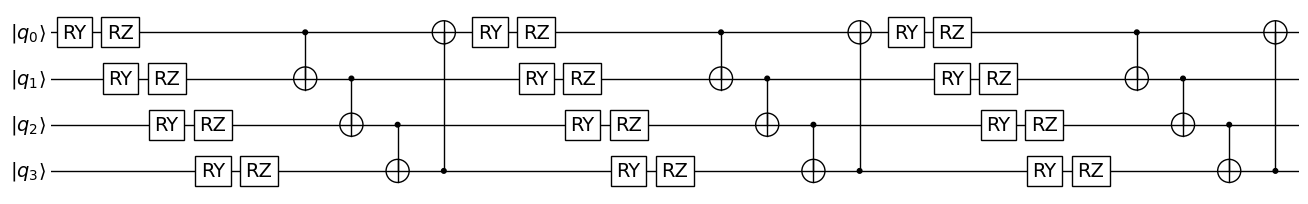

In [5]:
model = QuantumModel(
    circuit_structure=build_vqe_circuit(nqubits=nqubits, nlayers=nlayers),
    decoding=decoding,
    differentiation=None,
)

model.draw()

In [6]:
print("Exact ground state: ", min(hamiltonian.eigenvalues()))

Exact ground state:  tensor(-6.7446, dtype=torch.float64)


In [7]:
optimizer = optim.Adam(model.parameters(), lr=0.05)

for iteration in range(200):
    optimizer.zero_grad()  
    cost = model()  
    cost.backward()  
    optimizer.step()  

    if iteration % 20 == 0:
        print(f"Iteration {iteration}: Cost = {cost.item():.6f}")

Iteration 0: Cost = 0.798020
Iteration 20: Cost = -3.750246
Iteration 40: Cost = -6.350567
Iteration 60: Cost = -6.683885
Iteration 80: Cost = -6.733274
Iteration 100: Cost = -6.738381
Iteration 120: Cost = -6.740079
Iteration 140: Cost = -6.740863
Iteration 160: Cost = -6.741506
Iteration 180: Cost = -6.742051
